In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, ValidationCurveDisplay
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline

from xgboost.sklearn import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.rcParams["font.size"] = 14.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [15]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data.set_index("date", inplace = True)

Attribute Information:
date time year-month-day hour:minute:second

Appliances, energy use in Wh (target variable for prediction)

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

In [218]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,moving_avg,week_of_year,day_of_year
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,NaN,2,11
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,NaN,2,11
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,NaN,2,11
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,NaN,2,11
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,NaN,2,11


In [317]:
# melted_data = pd.melt(data.drop("date", axis=1))
# plt.figure(figsize=(20, 15))
# sns.boxplot(x="value", y="variable", data = melted_data)

# plt.xlabel("Values")
# plt.ylabel("Features")

# plt.tight_layout()
# plt.show()

In [216]:
data[["RH_6", "RH_out"]].head()

,RH_6,RH_out
date,,
2016-01-11 17:00:00,84.256667,92.0
2016-01-11 17:10:00,84.063333,92.0
2016-01-11 17:20:00,83.156667,92.0
2016-01-11 17:30:00,83.423333,92.0
2016-01-11 17:40:00,84.893333,92.0


In [188]:
time_diffs = data.index.to_series().diff().dt.total_seconds().div(60)
time_diffs.mean()

10.0

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [14]:
data.describe().round(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour
count,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00
mean,97.69,3.80,21.69,40.26,20.34,40.42,22.27,39.24,20.86,39.03,19.59,50.95,7.91,54.61,20.27,35.39,22.03,42.94,19.49,41.55,7.41,755.52,79.75,4.04,38.33,3.76,24.99,24.99,11.50
std,102.52,7.94,1.61,3.98,2.19,4.07,2.01,3.25,2.04,4.34,1.84,9.02,6.09,31.15,2.11,5.11,1.96,5.22,2.01,4.15,5.32,7.40,14.90,2.45,11.79,4.20,14.50,14.50,6.92
min,10.00,0.00,16.79,27.02,16.10,20.46,17.20,28.77,15.10,27.66,15.33,29.82,-6.06,1.00,15.39,23.20,16.31,29.60,14.89,29.17,-5.00,729.30,24.00,0.00,1.00,-6.60,0.01,0.01,0.00
25%,50.00,0.00,20.76,37.33,18.79,37.90,20.79,36.90,19.53,35.53,18.28,45.40,3.63,30.02,18.70,31.50,20.79,39.07,18.00,38.50,3.67,750.93,70.33,2.00,29.00,0.90,12.50,12.50,6.00
50%,60.00,0.00,21.60,39.66,20.00,40.50,22.10,38.53,20.67,38.40,19.39,49.09,7.30,55.29,20.03,34.86,22.10,42.38,19.39,40.90,6.92,756.10,83.67,3.67,40.00,3.43,24.90,24.90,12.00
75%,100.00,0.00,22.60,43.07,21.50,43.26,23.29,41.76,22.10,42.16,20.62,53.66,11.26,83.23,21.60,39.00,23.39,46.54,20.60,44.34,10.40,760.93,91.67,5.50,40.00,6.57,37.58,37.58,17.00
max,1080.00,70.00,26.26,63.36,29.86,56.03,29.24,50.16,26.20,51.09,25.80,96.32,28.29,99.90,26.00,51.40,27.23,58.78,24.50,53.33,26.10,772.30,100.00,14.00,66.00,15.50,50.00,50.00,23.00


In [4]:
def histplots_grid(n_rows, n_cols, data, features = None):

    if features is None:
        features = [feature for feature in data.select_dtypes([int, float]).columns]
    
    width = n_cols * 4
    height = n_rows * 3
    
    fix, axes = plt.subplots(n_rows, n_cols, figsize = (width, height))
    
    if n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)
    
    for i, feature in enumerate(features):
        row, col = divmod(i, n_cols)
        
        if row >= n_rows:
            break
        
        ax = axes[row, col]
        sns.histplot(data[feature], ax = ax)
        ax.set_title(feature)
        ax.set_xlabel(None)
        ax.set_ylabel(None) 

    for j in range(i + 1, n_rows*n_cols):
        row, col = divmod(j, n_cols)
        axes[row, col].axis("off")

    plt.tight_layout()    
    plt.show()

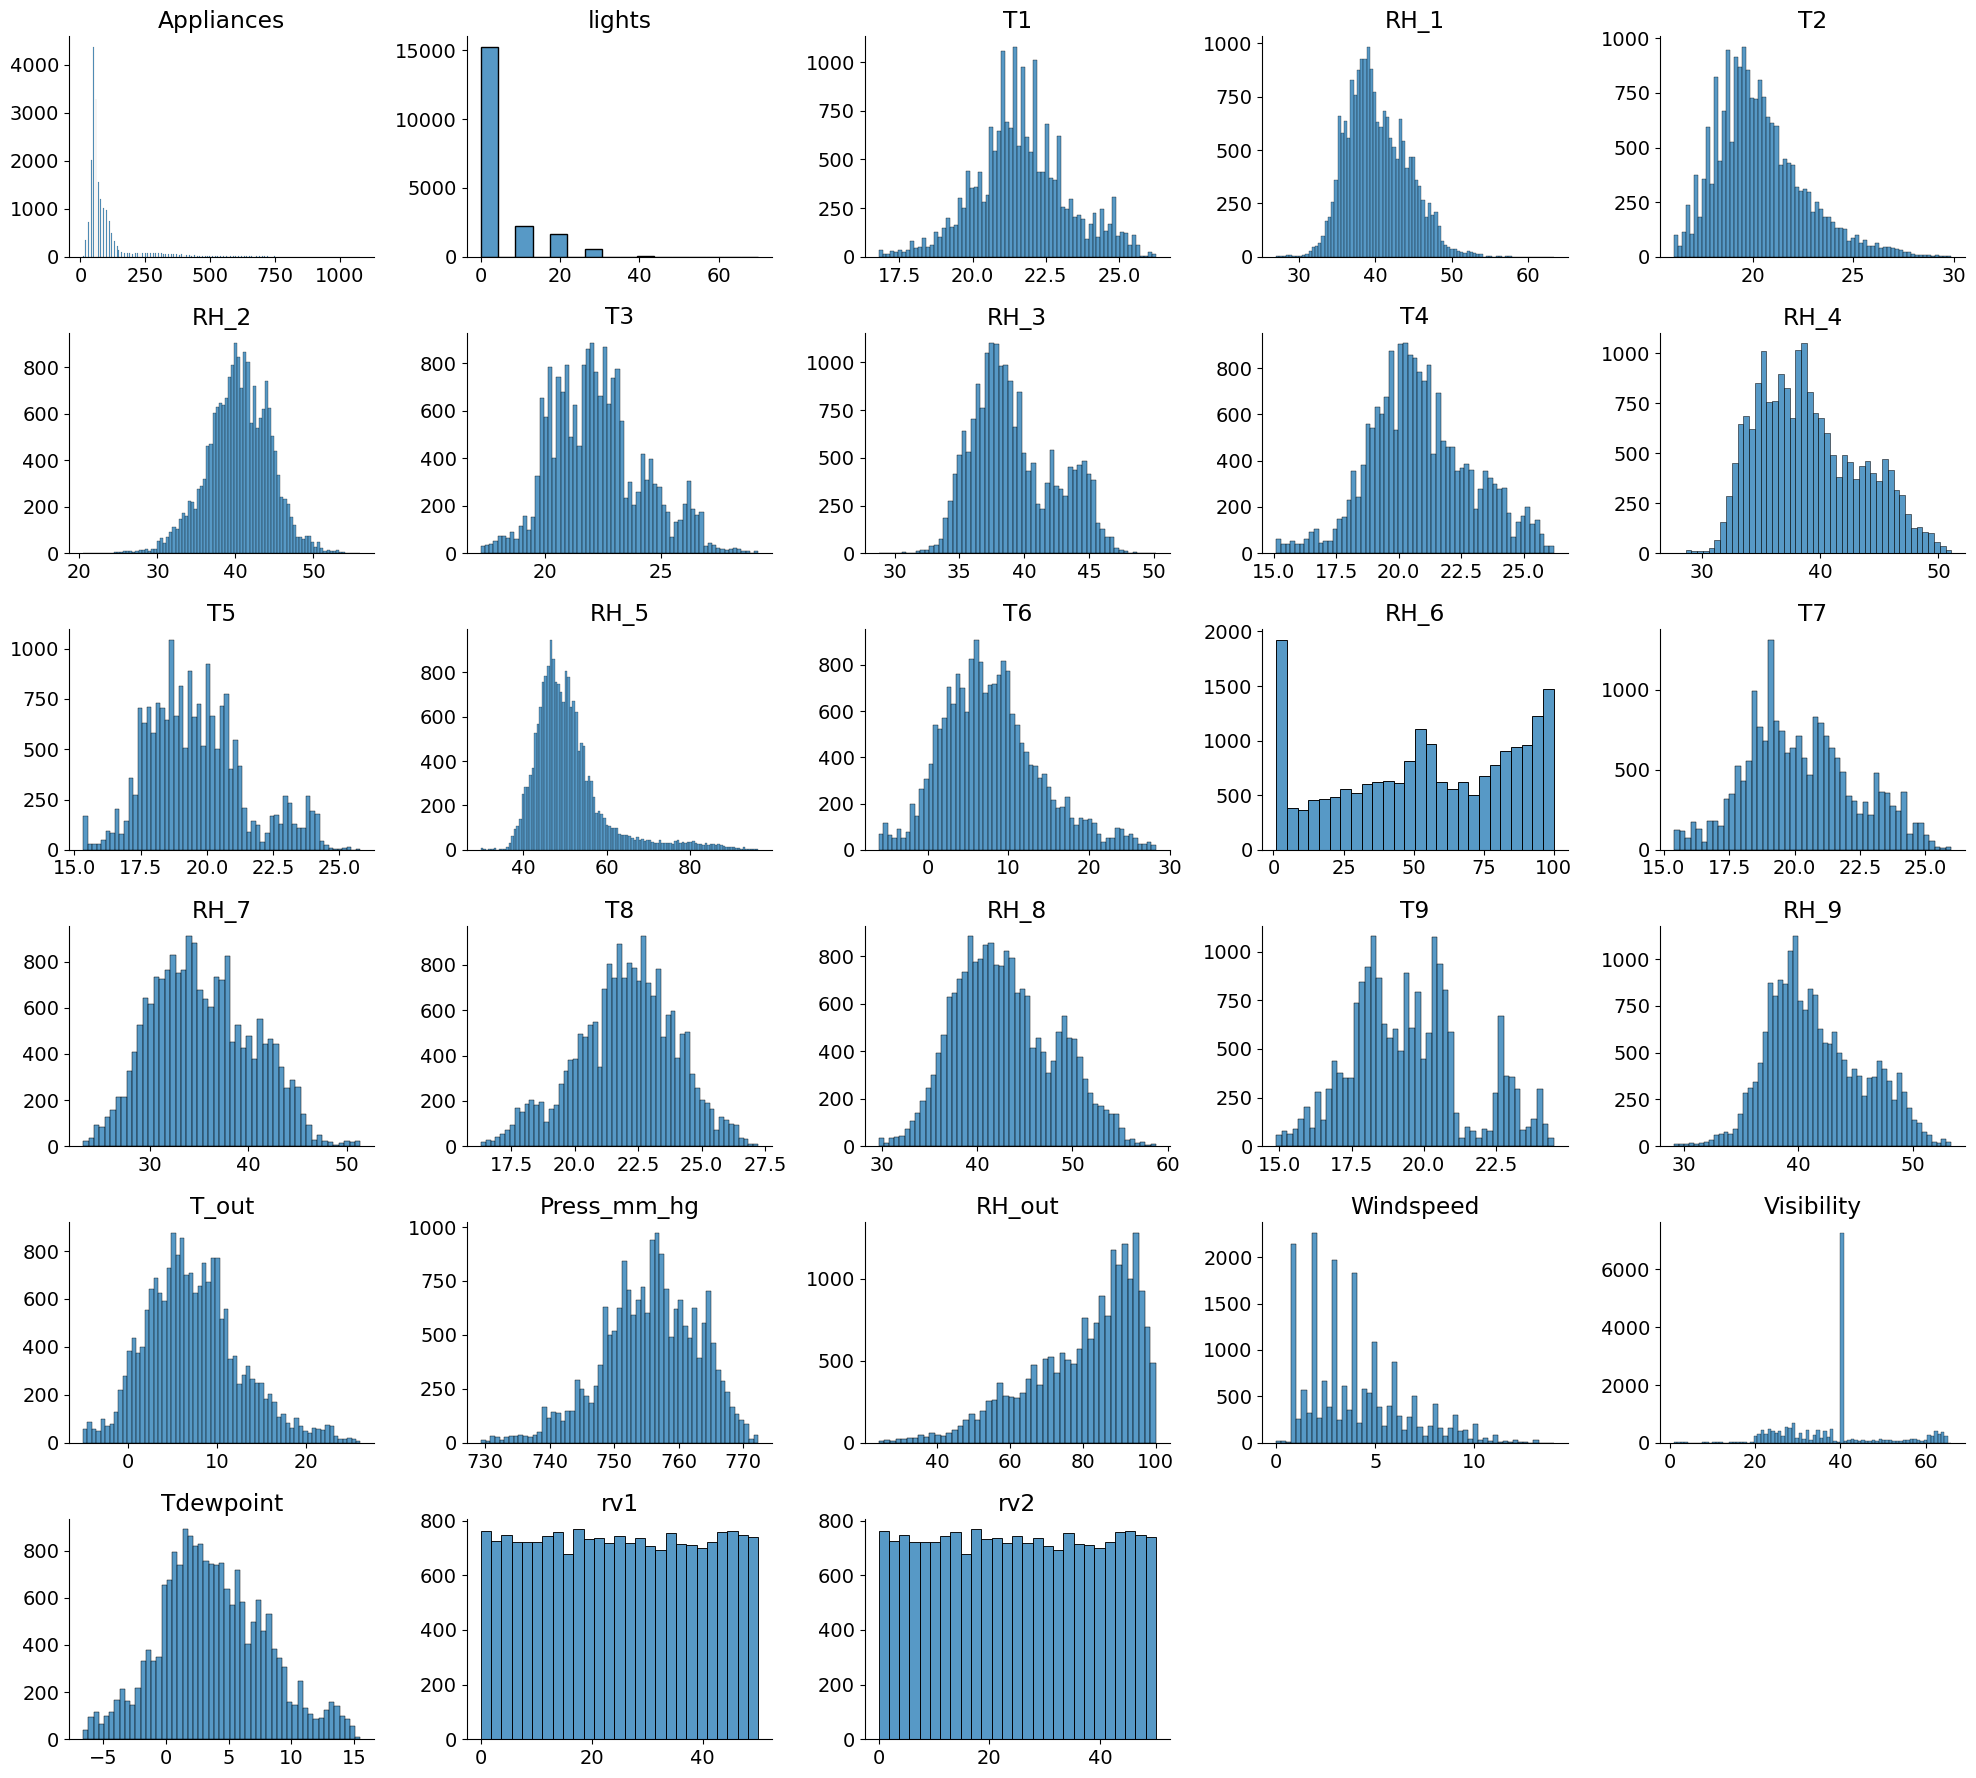

In [22]:
histplots_grid(6, 5, data)

In [177]:
pd.set_option("display.max_rows", None)
data[["T6", "RH_6", "T_out", "RH_out"]]
(data.RH_6 < 24.0).mean()

0.2072966810235622

## Looking at energy consumption over the entire time period covered by the data

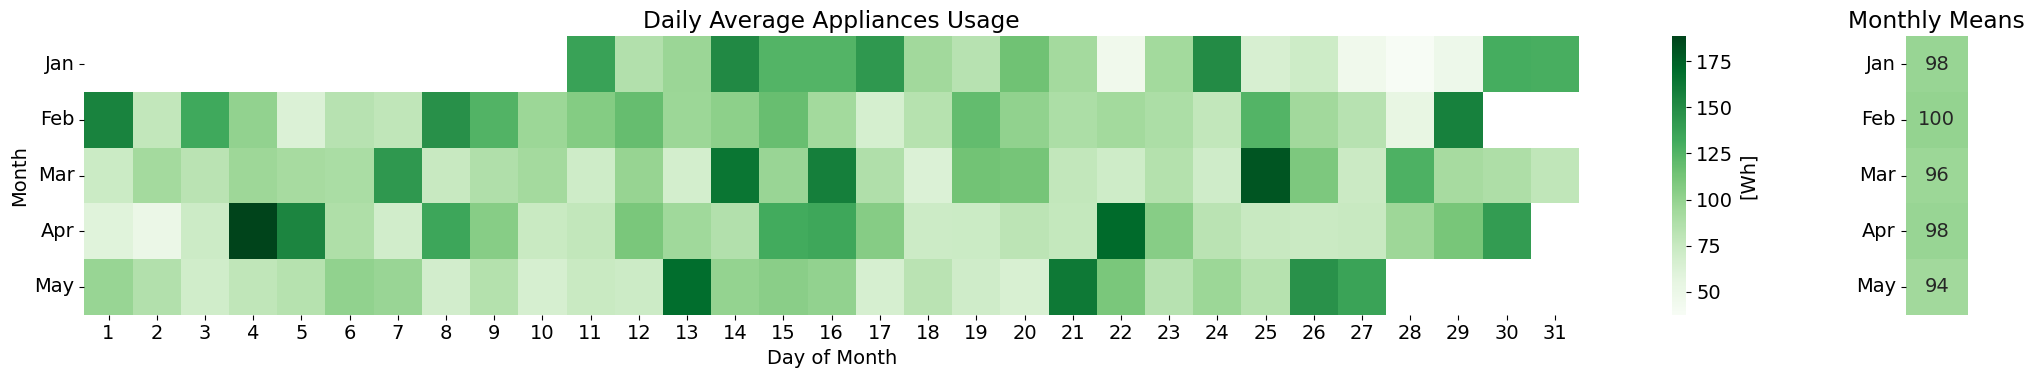

In [208]:
daily_data = data.Appliances.resample("D").mean()
heatmap_data = daily_data.groupby([daily_data.index.day, daily_data.index.month]).mean().unstack(level=0)
monthly_means = heatmap_data.mean(axis=1).to_frame("mean").astype(int)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 4), gridspec_kw = {"width_ratios": [30, 1]})

vmin = heatmap_data.min().min()
vmax = heatmap_data.max().max()
months = ["Jan", "Feb", "Mar", "Apr", "May"]

sns.heatmap(heatmap_data, cmap = "Greens", ax = ax1, vmin = vmin, vmax = vmax, cbar_kws = {"label": "[Wh]"})
ax1.set_title("Daily Average Appliances Usage")
ax1.set_xlabel("Day of Month")
ax1.set_ylabel("Month")
ax1.set_yticklabels(months, rotation = 0)
ax1.set_xticks(np.arange(31) + .5)
ax1.set_xticklabels(range(1, 32))

sns.heatmap(monthly_means, cmap = "Greens", cbar = False, annot = True, fmt = "d", ax = ax2, vmin = vmin, vmax = vmax)
ax2.set_title("Monthly Means")
ax2.set_ylabel(None)
ax2.set_yticklabels(months, rotation = 0)
ax2.set_xticks([])

plt.tight_layout()
plt.show()

In [335]:
days_to_remove = ['2016-01-01', '2016-01-27', '2016-01-28', '2016-01-29', '2016-04-01', '2016-04-02']
days_to_remove = pd.to_datetime(days_to_remove)

data = data[~data.index.normalize().isin(days_to_remove)]


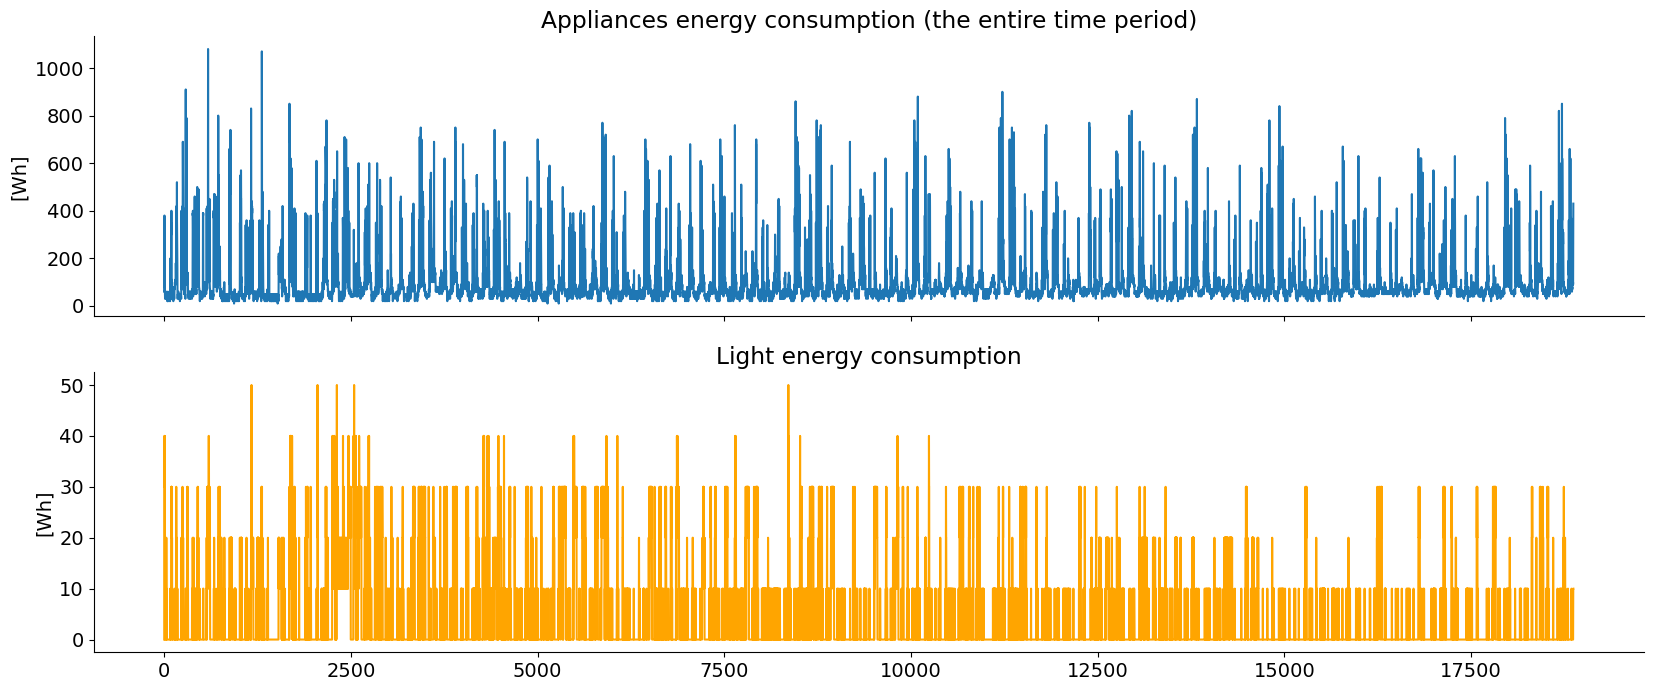

In [336]:
fig, ax = plt.subplots(2, 1, figsize = (20,8), sharex = True, subplot_kw={"ylabel":"[Wh]"})
sns.lineplot(x=range(data.shape[0]), y=data.Appliances, ax=ax[0], linestyle="-")
ax[0].set_title("Appliances energy consumption (the entire time period)")
# masked_lights = data.lights.where(data.lights == 0)
# ax[0].plot(range(data.shape[0]), masked_lights, color="orange", linestyle="-")
sns.lineplot(x=range(data.shape[0]), y=data.lights, ax=ax[1], color="orange", linestyle="-")
ax[1].set_title("Light energy consumption")
plt.show()

https://en.wikipedia.org/wiki/Belgium#Geography

https://www.timeanddate.com/holidays/belgium/2016

## Feature engineering

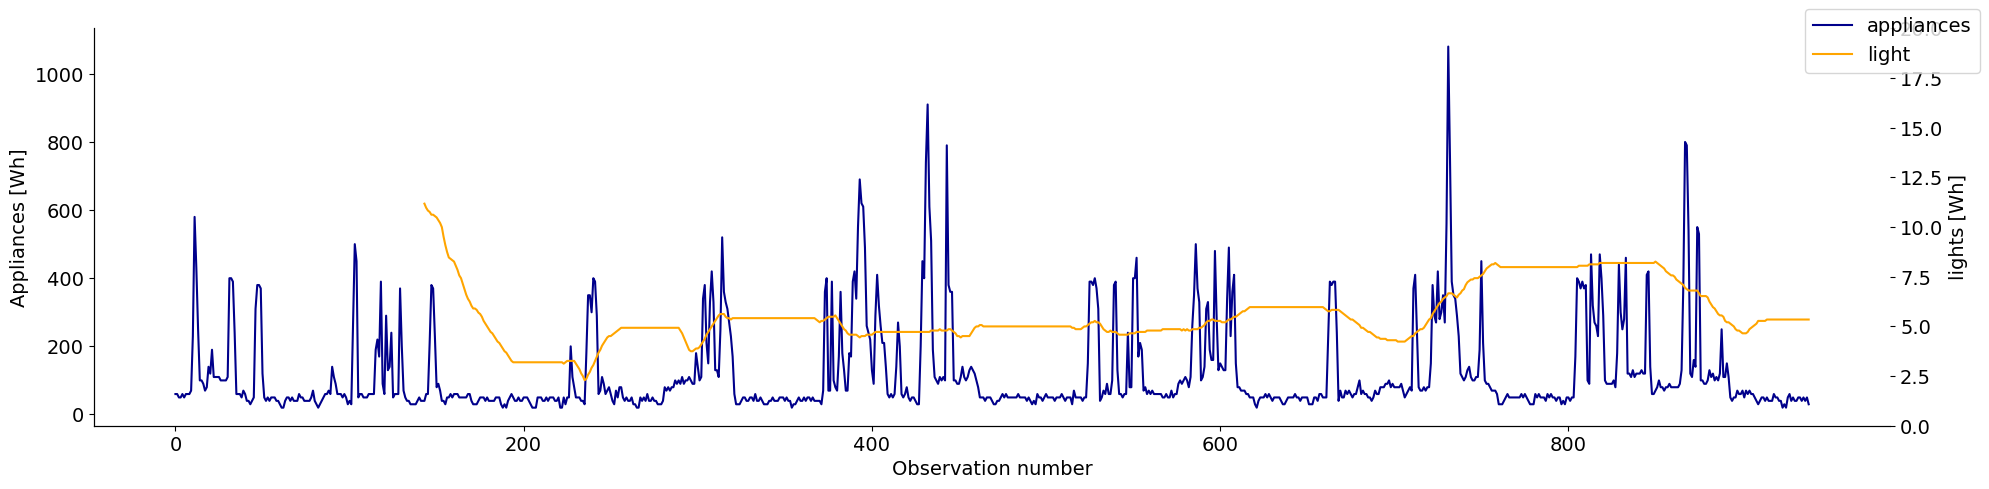

In [96]:
weekly_means = grouped_by_week['Appliances'].mean()

N = int(data.shape[0]/21)
fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_xlabel("Observation number")
ax1.set_ylabel("Appliances [Wh]")
ax1.plot(range(0, N), data.Appliances[:N], color="darkblue", linestyle="-", label = "appliances")
# ax1.set_ylim(-100, 900)
ax1.tick_params(axis='y')

data["moving_avg"] = data.lights.rolling(window=6*24).mean()
ax2 = ax1.twinx()  
ax2.set_ylabel('lights [Wh]')  
ax2.plot(range(0, N), data.moving_avg[:N], color="orange", alpha = 1, label = "light")
ax2.set_ylim(0, 20)
ax2.tick_params(axis='y')

fig.legend()
fig.tight_layout()
plt.show()

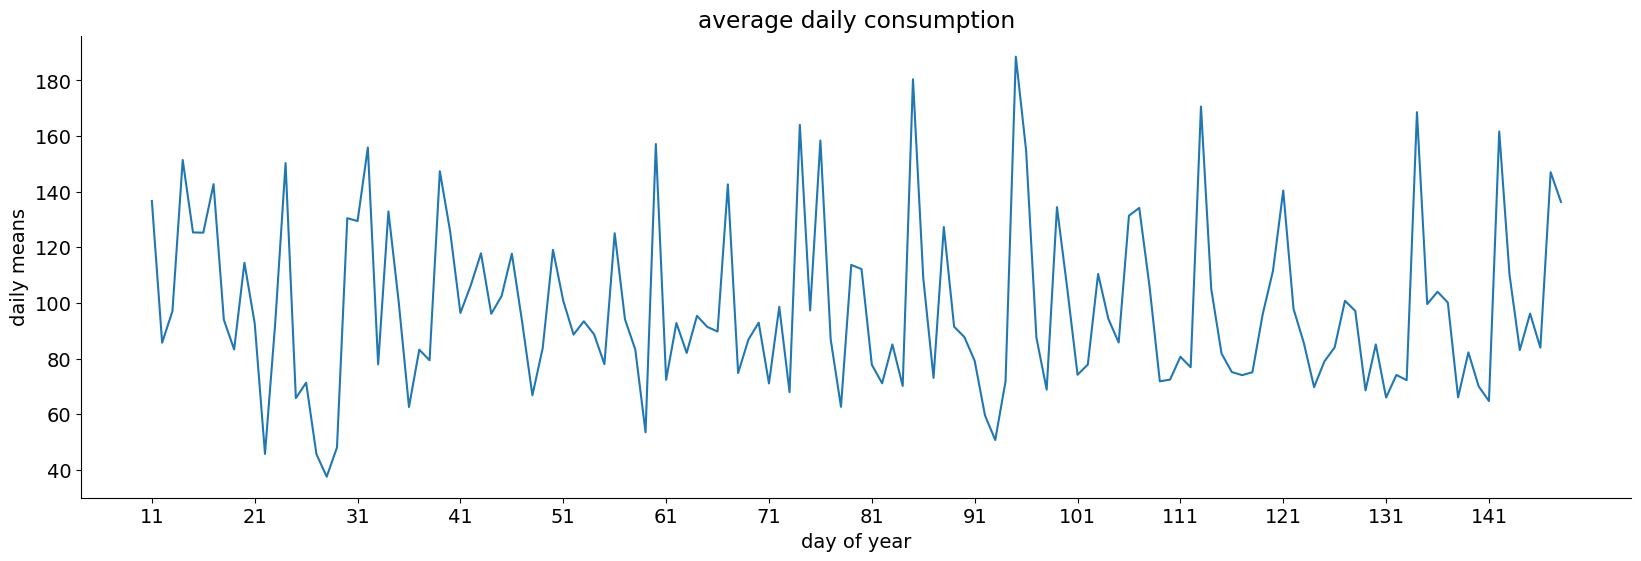

In [141]:
weekly_means = grouped_by_week['Appliances'].mean()
daily_means = grouped_by_day['Appliances'].mean()

plt.figure(figsize=(20, 6))
plt.plot(daily_means)
plt.title('average daily consumption')
plt.xlabel('day of year')
plt.ylabel('daily means')
plt.xticks(range(11, 149, 10))
# plt.grid(True)
plt.show()

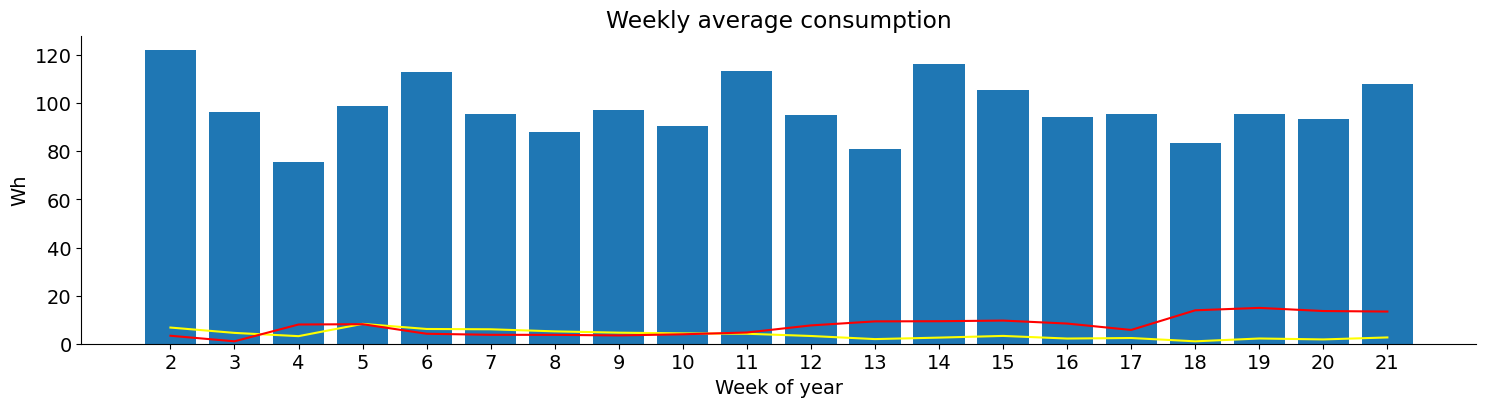

In [153]:
weekly_means = grouped_by_week['Appliances'].mean()
weekly_lights = grouped_by_week['lights'].mean()
temp_out = grouped_by_week['T_out'].mean()
plt.figure(figsize=(18, 4))
plt.bar(weekly_means.index, weekly_means.values)
plt.plot(weekly_means.index, weekly_lights, color="yellow")
plt.plot(weekly_means.index, temp_out, color="red")
plt.title('Weekly average consumption')
plt.xlabel('Week of year')
plt.ylabel('Wh')
plt.xticks(range(2, 22))
# plt.yscale("log")
plt.show()

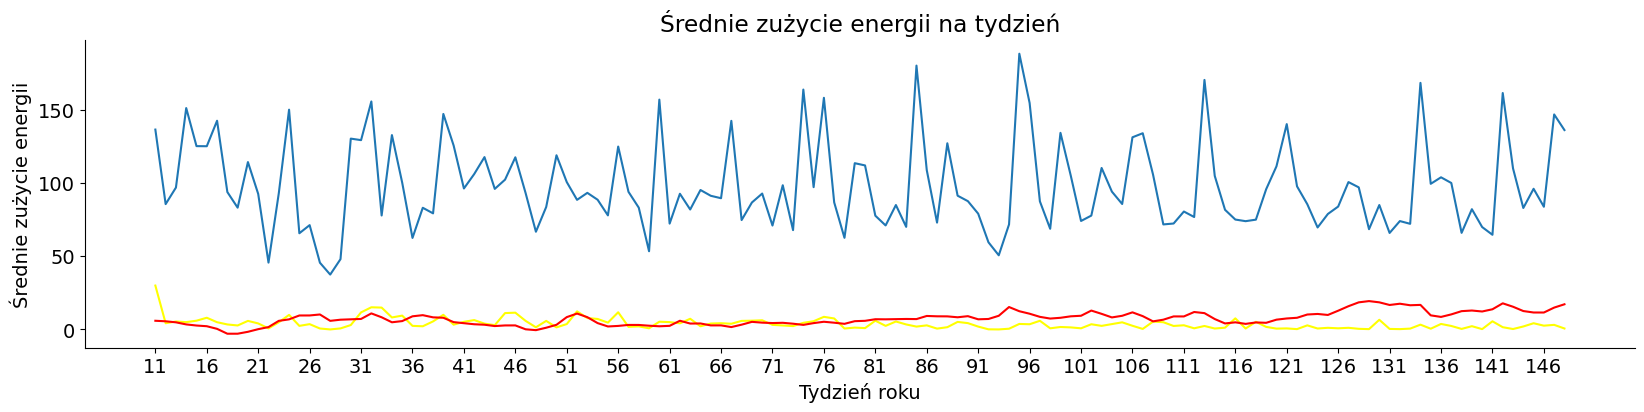

In [150]:
daily_means = grouped_by_day['Appliances'].mean()
daily_lights = grouped_by_day['lights'].mean()
temp_out = grouped_by_day['T_out'].mean()
plt.figure(figsize=(20, 4))
plt.plot(daily_means.index, daily_means.values)
plt.plot(daily_means.index, daily_lights, color="yellow")
plt.plot(daily_means.index, temp_out, color="red")
plt.title('Średnie zużycie energii na tydzień')
plt.xlabel('Tydzień roku')
plt.ylabel('Średnie zużycie energii')
plt.xticks(range(11, 149, 5))
# plt.yscale("log")
plt.show()

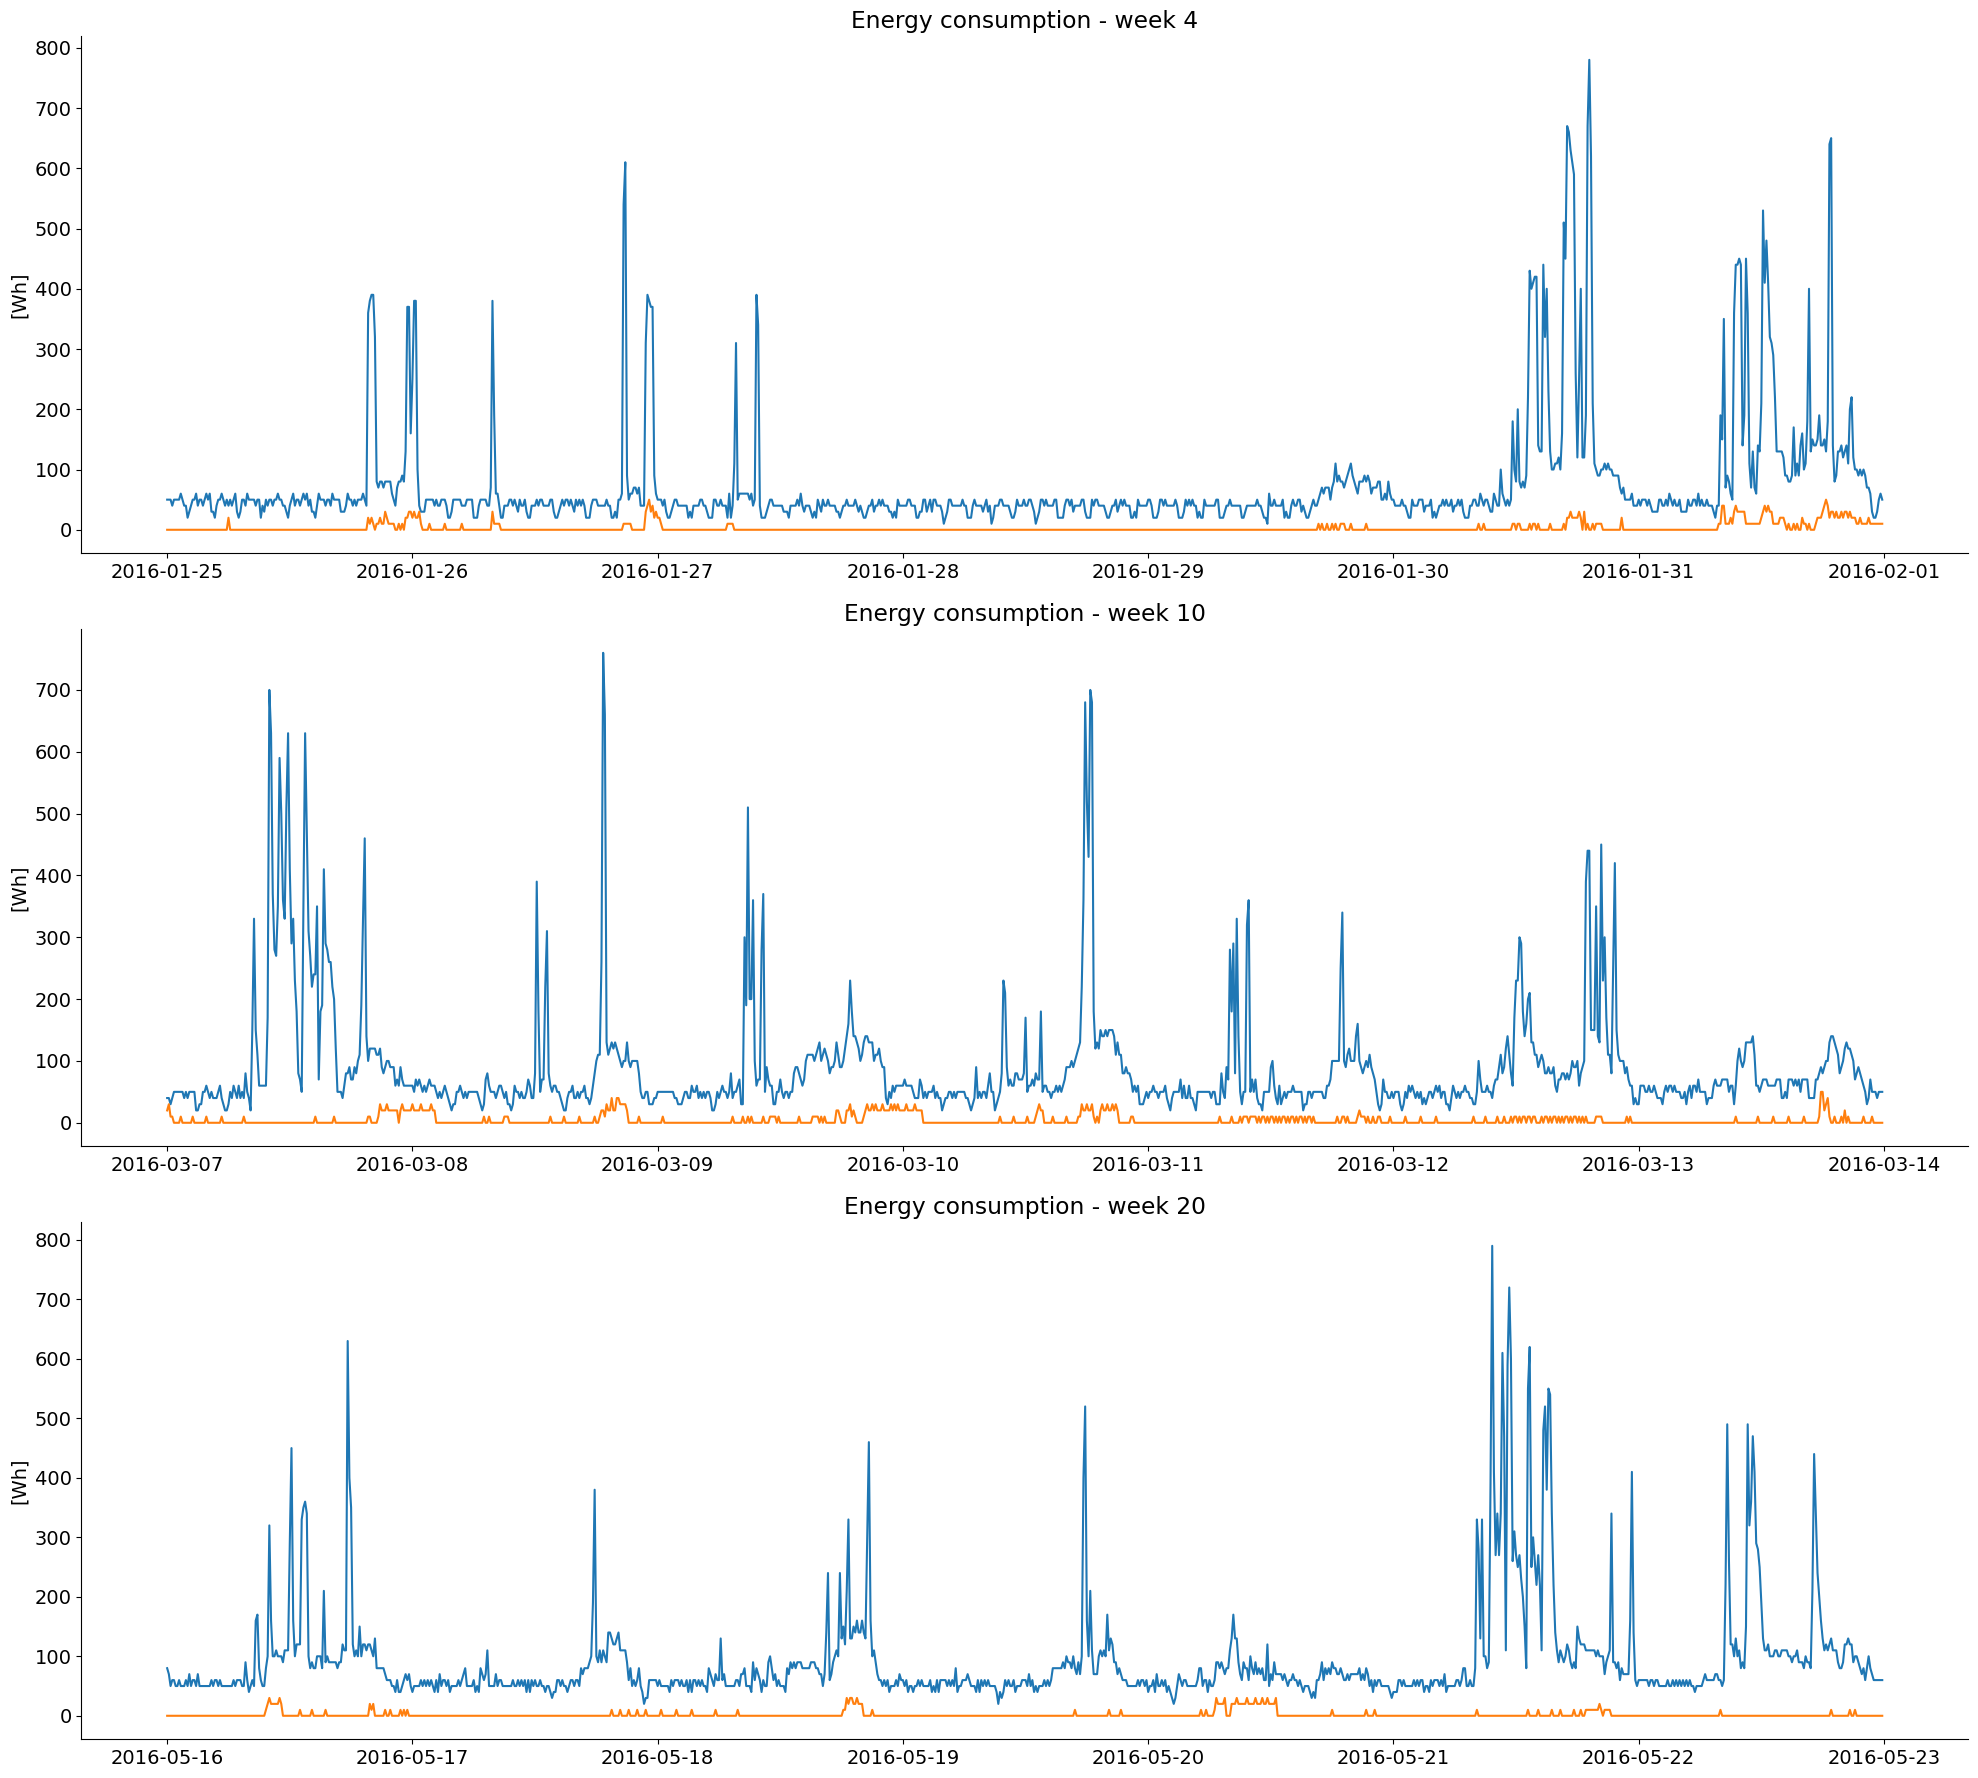

In [156]:
selected_weeks = [4, 10, 20]

plt.figure(figsize=(20, 6 * len(selected_weeks)))

for i, week in enumerate(selected_weeks, 1):
    plt.subplot(len(selected_weeks), 1, i)
    curr_week = grouped_by_week.get_group(week)
    plt.plot(curr_week['Appliances'])
    plt.plot(curr_week['lights'])
    plt.title(f'Energy consumption - week {week}')
    plt.ylabel('[Wh]')

plt.tight_layout()
plt.show()

In [345]:
data["app_1"] = data.Appliances.shift(6)

/tmp/ipykernel_2682/2001971427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["app_1"] = data.Appliances.shift(6)


In [346]:
for i in range(2, 25):
    data[f"app_{i}"] = data.Appliances.shift(i*6)

/tmp/ipykernel_2682/4232015993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"app_{i}"] = data.Appliances.shift(i*6)


In [347]:
pd.set_option("display.max_rows", 10)
data.head(10)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,moving_avg,app_1,app_2,app_3,app_4,app_5,app_6,app_7,app_8,app_9,app_10,app_11,app_12,app_13,app_14,app_15,app_16,app_17,app_18,app_19,app_20,app_21,app_22,app_23,app_24,hour,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,60,0,20.066667,42.833333,19.000000,42.418182,19.790000,44.700000,19.260000,42.560000,17.600000,50.900000,6.156667,18.138889,37.905556,18.600000,45.790000,17.100000,43.260000,6.50,744.200000,75.000000,7.000000,29.000000,2.30,36.465481,36.465481,10.972222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,False,False,False,False,False,True,False
2016-01-12 17:10:00,60,10,20.000000,42.672500,19.000000,42.433333,19.790000,44.663333,19.200000,42.560000,17.600000,50.900000,6.090000,18.100000,37.945455,18.600000,45.808333,17.100000,43.200000,6.32,744.283333,76.666667,7.000000,30.833333,2.43,22.628542,22.628542,10.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,False,False,False,False,False,True,False
2016-01-12 17:20:00,210,20,20.000000,42.530000,18.990000,42.471818,19.790000,44.590000,19.200000,42.626667,17.600000,50.790000,6.090000,18.100000,38.045000,18.600000,45.900000,17.100000,43.145000,6.13,744.366667,78.333333,7.000000,32.666667,2.57,8.756338,8.756338,10.763889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,False,False,False,False,False,True,False
2016-01-12 17:30:00,380,20,20.033333,43.496667,18.902222,42.580000,19.823333,44.590000,19.200000,42.760000,17.600000,50.730000,6.060000,18.018182,38.057273,18.536364,46.000000,17.100000,43.000000,5.95,744.450000,80.000000,7.000000,34.500000,2.70,37.334913,37.334913,10.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,False,False,False,False,False,True,False
2016-01-12 17:40:00,370,40,20.033333,42.963333,18.890000,42.560000,19.890000,44.590000,19.360000,43.566667,17.533333,50.790000,5.933333,18.000000,38.344167,18.500000,46.000000,17.100000,43.000000,5.77,744.533333,81.666667,7.000000,36.333333,2.83,5.249382,5.249382,10.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,False,False,False,False,False,True,False
2016-01-12 17:50:00,230,30,20.000000,43.160000,18.890000,42.796667,19.890000,44.590000,19.693333,43.900000,17.600000,50.790000,5.526667,18.066667,38.900000,18.500000,46.126667,17.066667,42.930000,5.58,744.616667,83.333333,7.000000,38.166667,2.97,43.227247,43.227247,10.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,False,False,False,False,False,True,False
2016-01-12 18:00:00,80,40,20.000000,43.900000,18.856667,43.400000,19.790000,44.466667,20.163333,43.833333,17.600000,50.745000,5.260000,18.133333,39.326667,18.500000,46.333333,17.000000,42.863333,5.40,744.700000,85.000000,7.000000,40.000000,3.10,30.732249,30.732249,10.486111,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,False,False,False,False,False,True,False
2016-01-12 18:10:00,90,30,20.000000,43.700000,18.856667,43.466667,19.790000,44.466667,20.290000,43.626667,17.500000,50.826667,5.060000,18.200000,39.326667,18.600000,46.626667,17.033333,42.826667,5.30,744.750000,86.000000,6.833333,40.000000,3.15,27.857977,27.857977,10.347222,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,False,False,False,False,False,True,False
2016-01-12 18:20:00,70,20,20.000000,43.760000,18.926667,43.363333,19.790000,44.400000,20.200000,43.490000,17.500000,50.900000,4.933333,18.245000,39.

In [136]:
data["day_of_year"] = data.index.day_of_year
grouped_by_day = data.groupby("day_of_year")

In [75]:
data["week_of_year"] = data.index.isocalendar().week

In [88]:
grouped_by_week = data.groupby("week_of_year")

In [95]:
# order = np.arange(2, 22)
grouped_by_week.Appliances.mean()

week_of_year
2     121.953642
3      96.190476
4      75.456349
5      98.888889
6     113.164683
7      95.704365
8      87.996032
9      97.251984
10     90.674603
11    113.581349
12     95.218254
13     81.101190
14    116.230159
15    105.674603
16     94.166667
17     95.704365
18     83.541667
19     95.654762
20     93.561508
21    107.912409
Name: Appliances, dtype: float64

In [227]:
# data = pd.read_csv(file_path)
# data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data["day_of_week"] = data.index.day_name()
data["hour"] = data.index.hour

grouped_data = data.groupby(["day_of_week", "hour"])["Appliances"].mean().unstack()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
grouped_data = grouped_data.reindex(order)

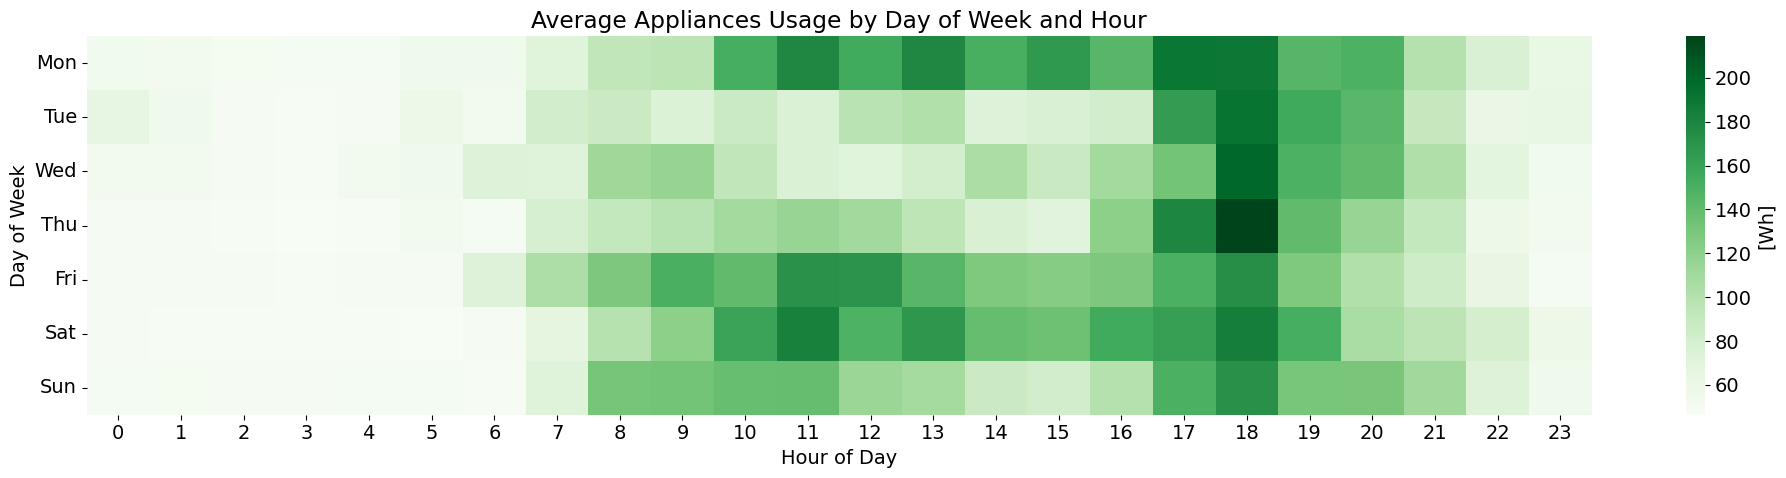

In [40]:
plt.figure(figsize=(20, 5))
sns.heatmap(grouped_data, cmap="Greens",  cbar_kws = {"label": "[Wh]"})

plt.title("Average Appliances Usage by Day of Week and Hour")
plt.ylabel("Day of Week")
plt.yticks(ticks = np.arange(7) + .5, labels = [day[:3] for day in order])
plt.xlabel("Hour of Day")

plt.tight_layout()
plt.show()

In [348]:
data = data.dropna()

In [231]:
data.drop(["week_of_year", "day_of_year"], axis=1, inplace=True)

/tmp/ipykernel_2682/3503485525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["week_of_year", "day_of_year"], axis=1, inplace=True)


In [233]:
data = pd.get_dummies(data)

In [261]:
data.drop("RH_6", axis=1, inplace=True)

In [286]:
data = pd.read_csv(file_path)
data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data['day_of_week'] = data['date'].dt.day_name()
data['hour'] = data['date'].dt.hour

In [349]:
X = data.drop("Appliances", axis = 1)
y = data.Appliances

# X['day_of_week'] = OrdinalEncoder().fit_transform(X[['day_of_week']])

In [350]:
X.shape

(18727, 59)

In [351]:
n_train = int(0.95 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

In [352]:
n_train

17790

In [353]:
model = ExtraTreesRegressor(min_samples_leaf=20, random_state=42)
model.fit(X_train, y_train)

ExtraTreesRegressor(min_samples_leaf=20, random_state=42)

In [354]:
y_pred = model.predict(X_test)
err = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
err, mse

(0.3772306510506444, 10290.152290121925)

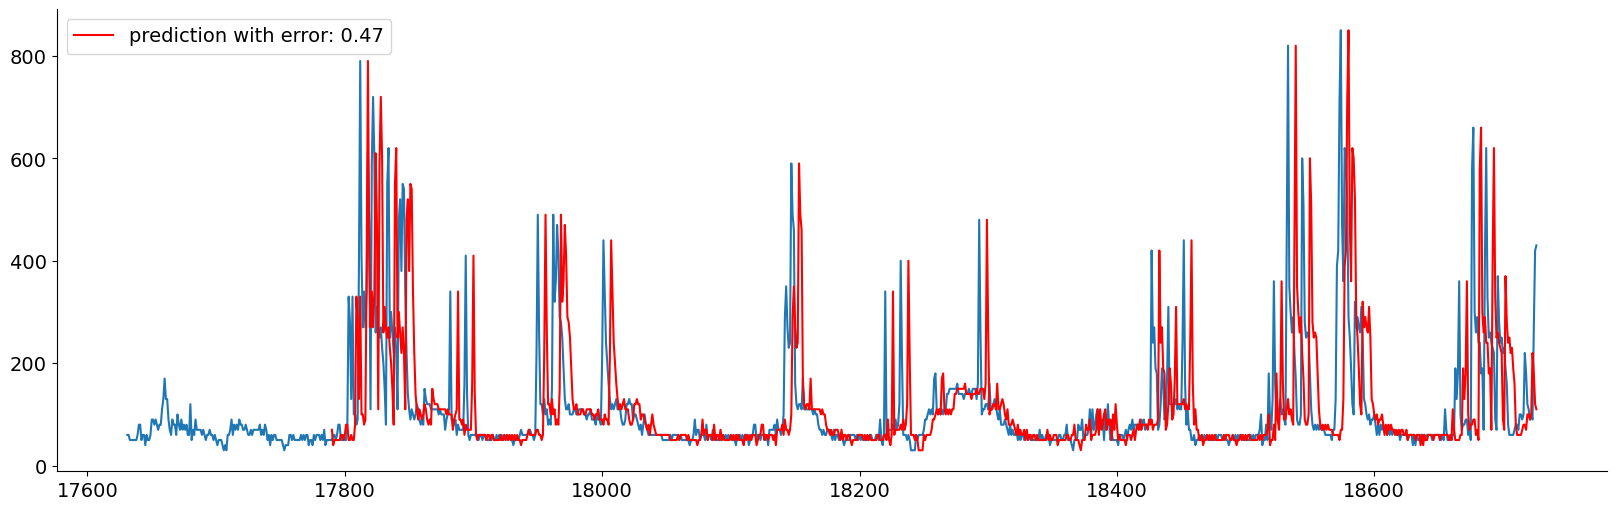

In [355]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(17631, N), data.Appliances[17631:])
plt.plot(range(n_train, N), X_test.app_1,
        color="red", label=f"prediction with error: {mean_absolute_percentage_error(y_test, X_test.app_1).round(2)}")
plt.legend()
plt.show()

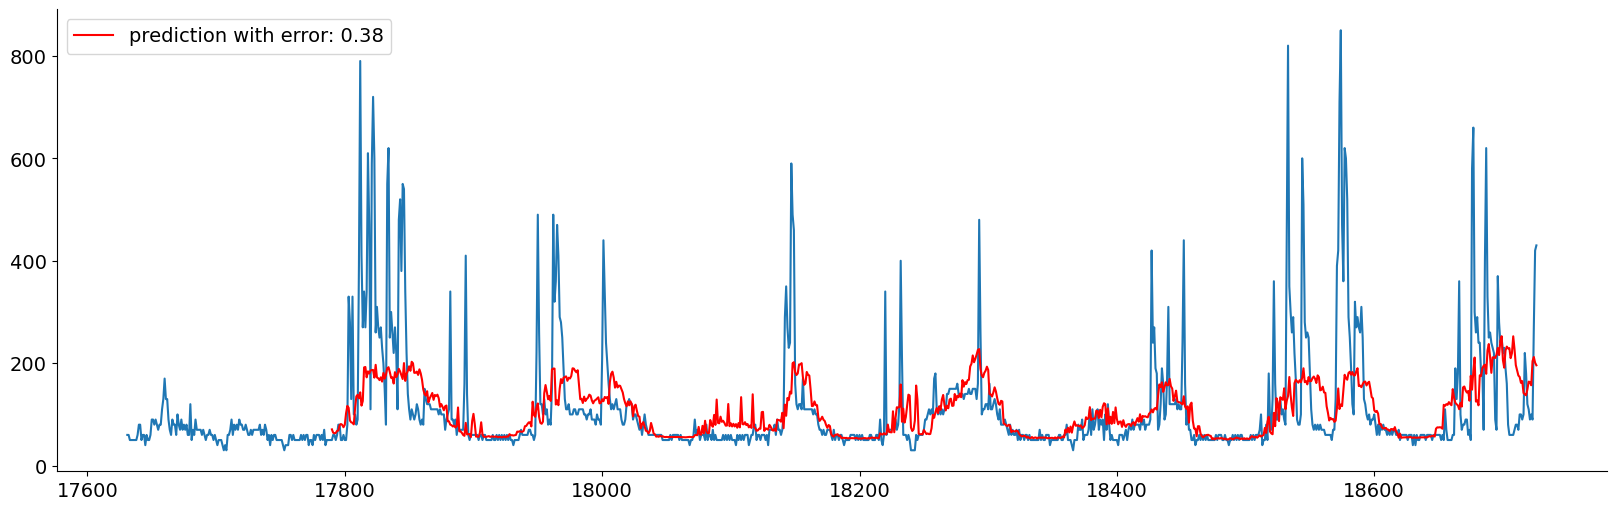

In [356]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(17631, N), data.Appliances[17631:])
plt.plot(range(n_train, N), y_pred,
        color="red", label=f"prediction with error: {mean_absolute_percentage_error(y_test, y_pred).round(2)}")
plt.legend()
plt.show()

In [357]:
all_results = {}

for model in [LinearRegression(), 
              Ridge(), 
              Lasso(), 
              DecisionTreeRegressor(min_samples_leaf=50),
              ExtraTreesRegressor(min_samples_leaf=20), 
              RandomForestRegressor(min_samples_leaf=20), 
              BaggingRegressor(n_estimators=100, max_samples=0.5), 
              HistGradientBoostingRegressor()]:

    results = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    err = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results["mape"] = err
    results["mse"] = mse
    
    all_results[model.__class__.__name__] = results
    
df = pd.DataFrame.from_dict(all_results, 
                            orient = "index", 
                            columns = ["mape", "mse"])

In [358]:
df

,mape,mse
LinearRegression,0.486989,10024.119198
Ridge,0.486954,10024.074354
Lasso,0.435425,10103.669195
DecisionTreeRegressor,0.448438,10981.668253
ExtraTreesRegressor,0.374239,10285.473563
RandomForestRegressor,0.427843,9936.930005
BaggingRegressor,0.601050,11306.381110
HistGradientBoostingRegressor,0.410584,10769.284170
